In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [7]:
df = pd.read_csv("../data/raw/hiv_cdhit_filtered.csv")

In [8]:
df

,Sequence,MIC,pIC50
0,ACWAAGIKQEF,333.000,8.007368
1,ACWGAGIKQEF,333.000,8.007368
2,ACWWAGIKAEF,333.000,8.007368
3,ACWWAGIKQAF,333.000,8.007368
4,ACWWAGIRQEF,333.000,8.007368
...,...,...,...
148,VWGIKQLQARILAVERYLKDQQLLGIWG,0.020,17.727534
149,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,0.008,18.643824
150,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,0.007,18.777356
151,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,0.005,19.113828


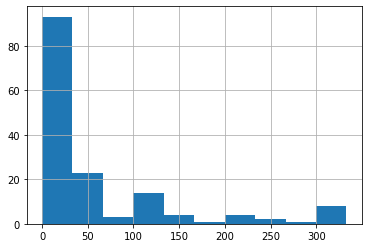

In [9]:
df['MIC'].hist()

In [10]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [11]:
df

,Sequence,MIC,pIC50
0,ACWAAGIKQEF,333.000,8.007368
1,ACWGAGIKQEF,333.000,8.007368
2,ACWWAGIKAEF,333.000,8.007368
3,ACWWAGIKQAF,333.000,8.007368
4,ACWWAGIRQEF,333.000,8.007368
...,...,...,...
148,VWGIKQLQARILAVERYLKDQQLLGIWG,0.020,17.727534
149,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,0.008,18.643824
150,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,0.007,18.777356
151,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,0.005,19.113828


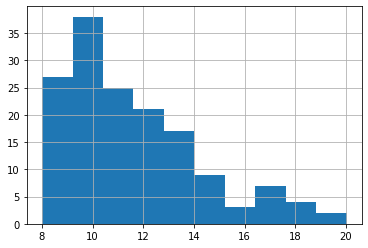

In [12]:
df['pIC50'].hist()

In [13]:
df['pIC50'].min(), df['pIC50'].max()

(8.00736806798383, 20.030118656386467)

In [22]:
molar = df['MIC']*1e-6
print(molar.min(), molar.max())

2e-09 0.00033299999999999996


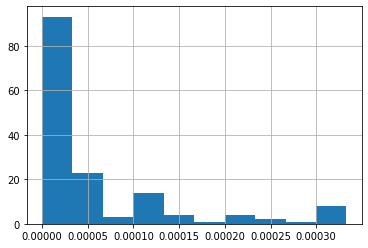

In [23]:
molar.hist()

In [63]:
log = -np.log(df['MIC'])
print(log.min(), log.max())

-5.808142489980444 6.214608098422191


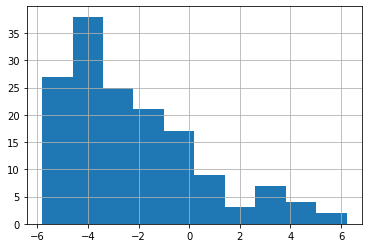

In [64]:
log.hist()

In [29]:
double_log = -np.log(df['pIC50']*1e-3)
print(double_log.min(), double_log.max())

3.9105182053885335 4.827393152672411


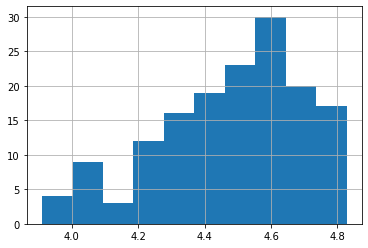

In [30]:
double_log.hist()

In [51]:
size = len(df['MIC'])-1
percentile_linearization = df['MIC'].rank(method='first').apply(lambda x: (x-1)/size)
print(percentile_linearization.min(), percentile_linearization.max())

0.0 1.0


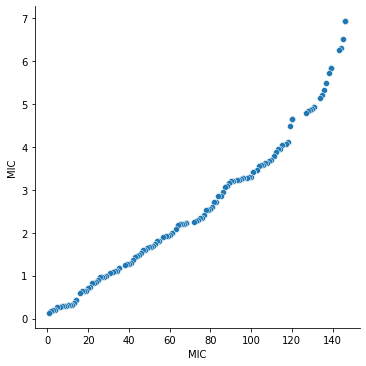

In [73]:
sns.relplot(x=df['MIC'].rank(method='min'), y=(df['MIC'])**(1/3))

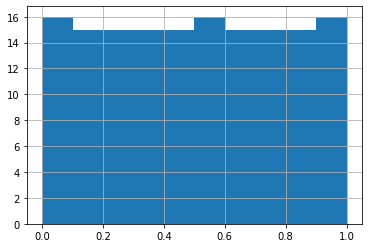

In [72]:
percentile_linearization.hist()

In [32]:
df['MIC'].skew()

2.086133580846542

In [33]:
df['pIC50'].skew()

0.9710364225350958

In [53]:
percentile_linearization.skew()

0.0

In [34]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [14]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1117.09sequence/s]


In [15]:
physicochemical_prop = get_physicochemical_properties(df)

In [16]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [17]:
y = df[['pIC50', 'MIC']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [20]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [21]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)